https://youtu.be/KL4JwpuHdsU

**Segmenting whole slide images using a custom-trained YOLO v8 model:**

<p>

We will be using a YOLOv8 trained model that we generated in our tutorial 336 (Github code starting with 336b).

<p>
This code walks you though the process of loading a WSI image (.svs format) and segmenting it by dividing the image into various tiles. Then, putting the tiles back into a large image (also handling the labels from the overlapped regions). Finally, saving the segmented large image.


<p>

**Segmenting a whole slide image (WSI) - e.g., .svs image** <p>

Sample svs file: https://github.com/camicroscope/Distro/blob/master/images/sample.svs
<p>

A few large svs images can be downloaded from here: https://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/ <p>


Please note that these are random files and have nothing to do with our training data. Therefore, not all nuclei will be segmented but we hope for some decent results. Ideally, you'd be segmenting images that are similar to our training data OR add more images to the training data to generalize the model.

In [ ]:
# Install the ultralytics package using pip
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 5.3 MB/s eta 0:00:00


In [ ]:
# Let us make sure colab understands UTF-8.
# Without this Colab is giving an error when installing imagecodecs
# Obviously something that is relevant only for colab.
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# To read Tiff files on Colab we need to install imagecodecs library
# This is a dependency of openslide library that we will be using to read .svs file
!pip install imagecodecs
# Install openslide
!pip install openslide-python
# Let us also install another dependency of openslide library
!sudo apt-get install libopenslide0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openslide-python: filename=openslide_python-1.3.0-cp310-cp310-linux_x86_64.whl size=33546 sha256=7b9c7ba34cae886198c315c778d3a248321f8f4d73c80e12f71654741b78944e
  Stored in directory: /root/.cache/pip/wheels/4d/a0/e6/e94ffceb76b28f1be2f59303ad58fdcf11822caa64960ed352
Successfully built openslide-python
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libopenslide0
0 upgraded, 1 newly installed, 0 to remove and 17 not upgraded.
Need to get 89.8 kB of archives.
After this operation, 223 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Fetched 89.8 kB in 0s (466 kB/s)
debcon

In [ ]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

Load the model and update weights using our trained model

In [ ]:
#Instance
model = YOLO('yolov8n-seg.yaml')  # build a new model from YAML
model = YOLO('//content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/yolo_dataset/results/50_epochs-/weights/last.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

Test the model on a single image, before applying it to a WSI


image 1/1 /content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/yolo_dataset/test/images/human_liver_22.png: 512x512 41 Nucleis, 16.2ms
Speed: 5.4ms preprocess, 16.2ms inference, 40.1ms postprocess per image at shape (1, 3, 512, 512)


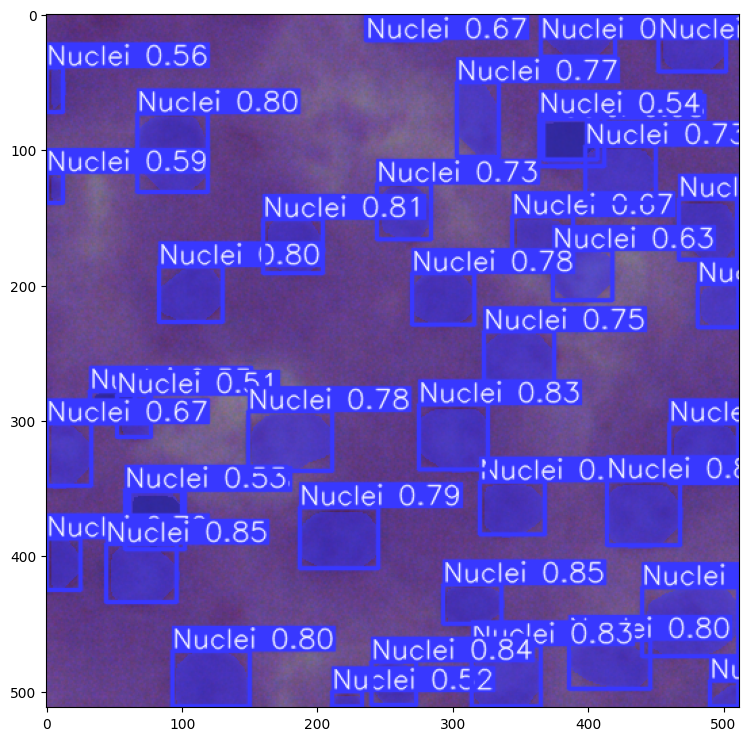

In [ ]:
new_image = '/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/yolo_dataset/test/images/human_liver_22.png'
new_results = model.predict(new_image, conf=0.3)  #Adjust conf threshold
new_result_array = new_results[0].plot()
plt.figure(figsize=(9, 9))
plt.imshow(new_result_array)

In [ ]:
import openslide
from skimage.measure import label
import numpy as np
import cv2
print(openslide.__version__)

1.3.0


In [ ]:
# Read the svs image (or any other WSI format)
slide = openslide.OpenSlide("/content/drive/MyDrive/ColabNotebooks/data/svs_files/sample.svs") #sample.svs & my_slide.svs
slide_dims = slide.dimensions
print(slide_dims)

(2220, 2967)


**Segmenting the large image by applying prediction tile by tile**

In the next step, let us break down the large image into smaller tiles, processes each tile to identify and label objects (Nuclei), and then stitch these processed tiles back together to create a full segmented mask of the original slide. <p>

We can svae the segmented mask as a 16-bit (or 32-bit) TIFF file for future use.

In [ ]:
import numpy as np
import tifffile  # to save our output as tiff
from skimage.measure import label  # for labeling the mask
from openslide import OpenSlide  # for reading slide images

# Parameters
tile_size = (512, 512)  # Size of the tile
overlap = 50  # Overlap between tiles

# Initialize an empty array to store the full mask
full_mask_shape = (slide.level_dimensions[-1][1], slide.level_dimensions[-1][0])
full_mask = np.zeros(full_mask_shape, dtype=np.uint16)

# Initialize a variable to keep track of the maximum label used so far
max_label = 0

# Loop through the slide and extract tiles
for x in range(0, slide.level_dimensions[0][0], tile_size[0] - overlap):
    #print(f"Processing column starting at x = {x}")  # Start of Outer Loop
    for y in range(0, slide.level_dimensions[0][1], tile_size[1] - overlap):
        #print(f"  Processing tile starting at (x, y) = ({x}, {y})")  # Start of Inner Loop

        # Calculate the size of the tile to read
        w, h = tile_size
        if x + w > slide.level_dimensions[0][0]:
            w = slide.level_dimensions[0][0] - x
        if y + h > slide.level_dimensions[0][1]:
            h = slide.level_dimensions[0][1] - y

        # Extract the tile from the slide
        tile = slide.read_region((x, y), 0, (w, h))
        tile_array = np.array(tile)[:, :, :3]  # Convert to NumPy array and keep only the RGB channels

        # Perform segmentation on the tile using your trained YOLO model
        new_results = model.predict(tile_array, conf=0.1)

        # Check if masks are available
        if new_results[0].masks is not None:
            extracted_masks = new_results[0].masks.data.cpu().numpy()  # Move to CPU and convert to NumPy array

            # Combine the masks
            combined_mask = np.sum(extracted_masks, axis=0)

            # Label the combined mask to give each object a unique integer value
            labeled_mask = label(combined_mask)

            # Update the labels to continue from where the last tile left off
            labeled_mask[labeled_mask > 0] += max_label

            # Update the maximum label used so far
            max_label = labeled_mask.max()

            print("    Segmentation complete.")  # After Segmentation

            # Update the full mask (handle overlaps using max pooling)
            for i in range(h):
                for j in range(w):
                    if y + i < full_mask_shape[0] and x + j < full_mask_shape[1]:  # Boundary check
                        full_mask[y + i, x + j] = max(full_mask[y + i, x + j], labeled_mask[i, j])
        else:
            print("    No detections for this tile.")

        print("    Full mask updated.")  # After Updating Full Mask


# Save the full mask as a 16-bit TIFF file
tifffile.imsave("/content/drive/MyDrive/ColabNotebooks/data/svs_files/yolo_output_mask.tiff", full_mask.astype(np.uint16))



0: 512x512 8 Nucleis, 8.3ms
Speed: 5.2ms preprocess, 8.3ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


    Segmentation complete.



0: 512x512 (no detections), 7.9ms
Speed: 5.7ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 16 Nucleis, 7.5ms
Speed: 4.8ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    No detections for this tile.
    Full mask updated.
    Segmentation complete.



0: 512x512 1 Nuclei, 7.8ms
Speed: 4.7ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 (no detections), 7.9ms
Speed: 5.4ms preprocess, 7.9ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 2 Nucleis, 7.5ms
Speed: 5.2ms preprocess, 7.5ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    No detections for this tile.
    Full mask updated.
    Segmentation complete.



0: 224x512 3 Nucleis, 66.4ms
Speed: 1.8ms preprocess, 66.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 28 Nucleis, 8.5ms
Speed: 4.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 23 Nucleis, 7.9ms
Speed: 5.8ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 29 Nucleis, 7.9ms
Speed: 5.2ms preprocess, 7.9ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 19 Nucleis, 7.9ms
Speed: 4.9ms preprocess, 7.9ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 17 Nucleis, 7.8ms
Speed: 5.2ms preprocess, 7.8ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 32 Nucleis, 7.8ms
Speed: 6.5ms preprocess, 7.8ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 224x512 20 Nucleis, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 512)

0: 512x512 35 Nucleis, 8.6ms
Speed: 5.5ms preprocess, 8.6ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.
    Full mask updated.
    Segmentation complete.



0: 512x512 131 Nucleis, 10.2ms
Speed: 5.3ms preprocess, 10.2ms inference, 4.3ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 91 Nucleis, 7.9ms
Speed: 5.7ms preprocess, 7.9ms inference, 5.0ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 21 Nucleis, 15.4ms
Speed: 12.4ms preprocess, 15.4ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.


    Full mask updated.


0: 512x512 49 Nucleis, 42.4ms
Speed: 25.2ms preprocess, 42.4ms inference, 3.5ms postprocess per image at shape (1, 3, 512, 512)


    Segmentation complete.



0: 512x512 30 Nucleis, 7.7ms
Speed: 5.8ms preprocess, 7.7ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 224x512 11 Nucleis, 8.4ms
Speed: 3.0ms preprocess, 8.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 512)

0: 512x512 12 Nucleis, 8.3ms
Speed: 5.4ms preprocess, 8.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.
    Full mask updated.
    Segmentation complete.



0: 512x512 63 Nucleis, 7.7ms
Speed: 6.3ms preprocess, 7.7ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 60 Nucleis, 35.7ms
Speed: 16.6ms preprocess, 35.7ms inference, 14.7ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 53 Nucleis, 10.0ms
Speed: 5.5ms preprocess, 10.0ms inference, 2.9ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 60 Nucleis, 8.1ms
Speed: 5.2ms preprocess, 8.1ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 512x512 34 Nucleis, 8.3ms
Speed: 5.2ms preprocess, 8.3ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 512)


    Full mask updated.
    Segmentation complete.



0: 224x512 18 Nucleis, 9.0ms
Speed: 3.9ms preprocess, 9.0ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 512)



    Full mask updated.
    Segmentation complete.
    Full mask updated.


0: 512x384 (no detections), 73.8ms
Speed: 2.5ms preprocess, 73.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 384)

0: 512x384 2 Nucleis, 10.1ms
Speed: 4.2ms preprocess, 10.1ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 384)


    No detections for this tile.
    Full mask updated.
    Segmentation complete.



0: 512x384 19 Nucleis, 7.6ms
Speed: 4.4ms preprocess, 7.6ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 384)


    Full mask updated.
    Segmentation complete.



0: 512x384 9 Nucleis, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 384)


    Full mask updated.
    Segmentation complete.



0: 512x384 16 Nucleis, 10.7ms
Speed: 4.2ms preprocess, 10.7ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 384)


    Full mask updated.
    Segmentation complete.



0: 512x384 8 Nucleis, 7.9ms
Speed: 4.1ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 384)


    Full mask updated.
    Segmentation complete.



0: 288x512 1 Nuclei, 67.5ms
Speed: 10.0ms preprocess, 67.5ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 512)


    Full mask updated.
    Segmentation complete.
    Full mask updated.


<ipython-input-9-9bdaa629f869>:67: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave("/content/drive/MyDrive/ColabNotebooks/data/svs_files/yolo_output_mask.tiff", full_mask.astype(np.uint16))


In [ ]:
# Export the entire raw image at the desired level, optional step if you want to compare results locally
desired_level = 0  # User-defined level
raw_image_pil = slide.read_region((0, 0), desired_level, slide.level_dimensions[desired_level])
raw_image = np.array(raw_image_pil)[:, :, :3]  # Convert to NumPy array and keep only the RGB channels
tifffile.imwrite(f"/content/drive/MyDrive/ColabNotebooks/data/svs_files/raw_image_level_{desired_level}.tiff", raw_image)


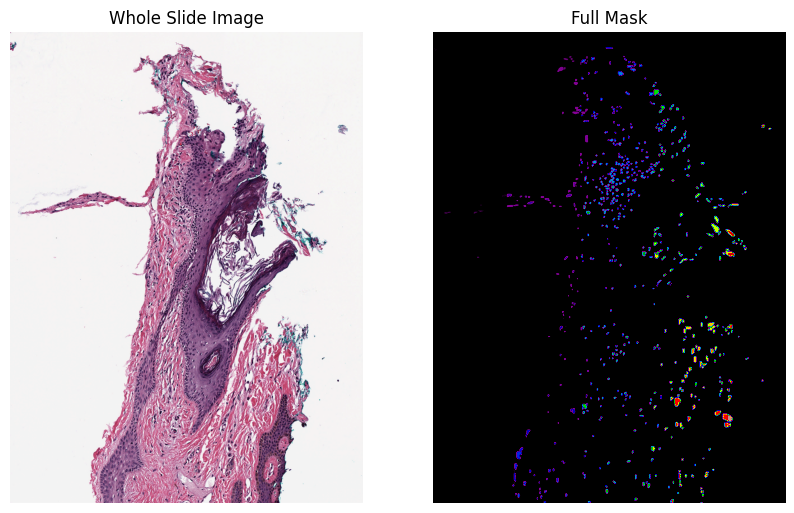

In [ ]:
import matplotlib.pyplot as plt

# Read the entire slide at the lowest resolution
lowest_level = len(slide.level_dimensions) - 1
whole_slide_image = slide.read_region((0, 0), lowest_level, slide.level_dimensions[lowest_level])
whole_slide_image = whole_slide_image.convert("RGB")  # Convert to RGB
whole_slide_image = np.array(whole_slide_image)  # Convert to NumPy array

# Plotting the whole slide image
plt.figure(figsize=(10, 120))

plt.subplot(1, 2, 1)
plt.imshow(whole_slide_image)
plt.title('Whole Slide Image')
plt.axis('off')

# Plotting the full mask
plt.subplot(1, 2, 2)
plt.imshow(full_mask, cmap='nipy_spectral')
plt.title('Full Mask')
plt.axis('off')

plt.show()
